In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the data
file_path = 'car-price_data.csv'
data = pd.read_csv(file_path)

# Keep specified columns
selected_columns = [
    "Make", "Model", "Year", "Engine HP", "Engine Cylinders",
    "Transmission Type", "Vehicle Style", "highway MPG", "city mpg", "MSRP"
]
data = data[selected_columns]

# Lowercase column names and replace spaces with underscores
data.columns = data.columns.str.lower().str.replace(' ', '_')

# Fill missing values with 0
data = data.fillna(0)

# Make MSRP binary
average_msrp = data['msrp'].mean()
data['above_average'] = (data['msrp'] > average_msrp).astype(int)

# Drop the original 'msrp' column
data = data.drop(columns=['msrp'])

# Split the data
train_data, temp_data = train_test_split(data, test_size=0.4, random_state=1)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=1)

# Check the shapes of the resulting dataframes
train_data.shape, val_data.shape, test_data.shape, data.head()


((7148, 10),
 (2383, 10),
 (2383, 10),
   make       model  year  engine_hp  engine_cylinders transmission_type  \
 0  BMW  1 Series M  2011      335.0               6.0            MANUAL   
 1  BMW    1 Series  2011      300.0               6.0            MANUAL   
 2  BMW    1 Series  2011      300.0               6.0            MANUAL   
 3  BMW    1 Series  2011      230.0               6.0            MANUAL   
 4  BMW    1 Series  2011      230.0               6.0            MANUAL   
 
   vehicle_style  highway_mpg  city_mpg  above_average  
 0         Coupe           26        19              1  
 1   Convertible           28        19              1  
 2         Coupe           28        20              0  
 3         Coupe           28        18              0  
 4   Convertible           28        18              0  )

### Question 1: ROC AUC for Numerical Features

In [2]:
from sklearn.metrics import roc_auc_score

# Numerical features to evaluate
numerical_features = ["engine_hp", "engine_cylinders", "highway_mpg", "city_mpg"]
target_variable = "above_average"

# Calculate AUC for each numerical feature
auc_scores = {}

for feature in numerical_features:
    score = roc_auc_score(train_data[target_variable], train_data[feature])
    # If AUC is < 0.5, negate the feature
    if score < 0.5:
        score = roc_auc_score(train_data[target_variable], -train_data[feature])
    auc_scores[feature] = score

# Find the feature with the highest AUC
max_auc_feature = max(auc_scores, key=auc_scores.get)

auc_scores, max_auc_feature


({'engine_hp': 0.9159001518508375,
  'engine_cylinders': 0.768274900593613,
  'highway_mpg': 0.6333685399678282,
  'city_mpg': 0.67232674562278},
 'engine_hp')

### Question 2: Training the Model & AUC on Validation Data

In [3]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Prepare X and y
def prepare_X(df):
    # Use DictVectorizer to handle categorical features
    dicts = df.drop(columns=[target_variable]).to_dict(orient='records')
    X = dv.transform(dicts)
    return X

def prepare_y(df):
    return df[target_variable].values

# One-hot encoding
train_dicts = train_data.drop(columns=[target_variable]).to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
y_train = prepare_y(train_data)

# Train logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Validate the model
val_dicts = val_data.drop(columns=[target_variable]).to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_val = prepare_y(val_data)

# AUC on validation data
y_pred_val = model.predict_proba(X_val)[:, 1]
auc_val = roc_auc_score(y_val, y_pred_val)

auc_val


0.9757005156393983

### Question 3: Precision and Recall


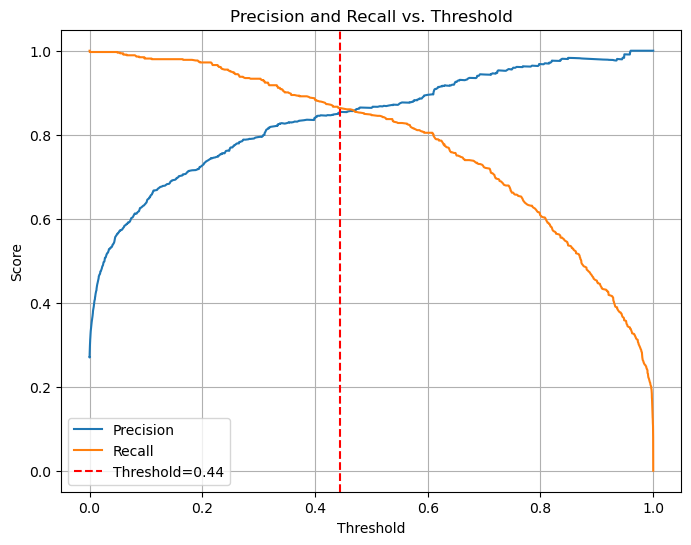

0.4444370258494808

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Predicted probabilities for class 1
y_pred = model.predict_proba(X_val)[:, 1]

# Precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)

# Find the threshold where precision and recall intersect
index_intersect = np.where(np.isclose(precision, recall, atol=0.01))[0]
threshold_intersect = thresholds[index_intersect][0]

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.axvline(threshold_intersect, color='red', linestyle='--', label=f'Threshold={threshold_intersect:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

threshold_intersect


### Question 4: F1 Score

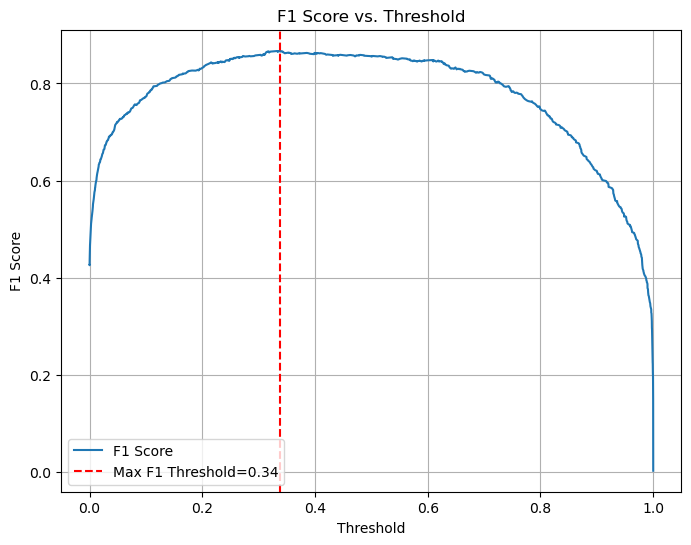

0.3375886442879868

In [6]:
# Calculating F1 score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the threshold where F1 score is maximal
max_f1_index = np.argmax(f1_scores[:-1])
threshold_max_f1 = thresholds[max_f1_index]

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.axvline(threshold_max_f1, color='red', linestyle='--', label=f'Max F1 Threshold={threshold_max_f1:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

threshold_max_f1


### Question 5: 5-Fold Cross-Validation

In [7]:
from sklearn.model_selection import KFold

# Initialize KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

# Prepare full train data
full_train = pd.concat([train_data, val_data]).reset_index(drop=True)
X_full_train = prepare_X(full_train)
y_full_train = prepare_y(full_train)

# AUC scores list
auc_scores = []

# Iterate over different folds
for train_idx, val_idx in kfold.split(X_full_train):
    # Split the data
    X_train_fold, X_val_fold = X_full_train[train_idx], X_full_train[val_idx]
    y_train_fold, y_val_fold = y_full_train[train_idx], y_full_train[val_idx]
    
    # Train the model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_fold, y_train_fold)
    
    # Validate the model
    y_pred = model.predict_proba(X_val_fold)[:, 1]
    auc = roc_auc_score(y_val_fold, y_pred)
    auc_scores.append(auc)

# Standard deviation of AUC scores
std_auc = np.std(auc_scores)

auc_scores, std_auc


([0.9798175897249045,
  0.9738142216059391,
  0.9831817550680366,
  0.9806496894782464,
  0.9809198848333376],
 0.003135797534732897)

### Question 6: Hyperparameter Tuning


In [8]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

# Assuming you have X_full_train and y_full_train defined somewhere in your code

# Initialize 5-Fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# C values to iterate over
C_values = [0.01, 0.1, 0.5, 10]

# Mean and std scores for each C
mean_std_scores = {}

# Iterate over different C values
for C in C_values:
    auc_scores = []
    # Iterate over different folds
    for train_idx, val_idx in kfold.split(X_full_train):
        # Split the data
        X_train_fold, X_val_fold = X_full_train[train_idx], X_full_train[val_idx]
        y_train_fold, y_val_fold = y_full_train[train_idx], y_full_train[val_idx]
        
        # Train the model
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_fold, y_train_fold)
        
        # Validate the model
        y_pred = model.predict_proba(X_val_fold)[:, 1]
        auc = roc_auc_score(y_val_fold, y_pred)
        auc_scores.append(auc)
    
    # Mean and standard deviation of AUC scores
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    mean_std_scores[C] = (mean_auc, std_auc)

# Find the C that leads to the best mean score
best_C = max(mean_std_scores, key=lambda k: (mean_std_scores[k][0], -mean_std_scores[k][1]))

print(mean_std_scores)
print("Best C:", best_C)


{0.01: (0.9508674341886441, 0.005231367492623007), 0.1: (0.9706387744826379, 0.004706984991664171), 0.5: (0.9763900463567012, 0.00430759431539506), 10: (0.9807746311566697, 0.003699760031465661)}
Best C: 10
